In [68]:
import pandas as pd
import geopandas as gpd

def load_geodataframes(file_paths):
    """Charge plusieurs fichiers CSV en GeoDataFrames et les stocke dans un dictionnaire."""
    geodfs = {}
    for name, file_path in file_paths.items():
        df = pd.read_csv(file_path)
        gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry']))
        geodfs[name] = gdf
    return geodfs

def merge_geodataframes(geodfs):
    """Fusionne plusieurs GeoDataFrames en conservant toutes les entrées uniques en utilisant les noms relatifs pour les géométries."""
    # Initialiser avec le premier GeoDataFrame
    merged_gdf = geodfs.pop(next(iter(geodfs)))  # Obtenez le premier élément du dictionnaire

    for name, gdf in geodfs.items():
        # Fusionner avec une jointure externe (outer join)
        merged_gdf = merged_gdf.merge(gdf, on='idx', how='outer', suffixes=('', f'_{name}_drop'))

    return merged_gdf

def resolve_geometry_columns(merged_gdf):
    """Résout les colonnes de géométrie supplémentaires en vérifiant et en consolidant les géométries."""
    # Trouver toutes les colonnes de géométrie
    geometry_columns = [col for col in merged_gdf.columns if col.startswith('geometry')]

    if len(geometry_columns) > 1:
        # Processus pour vérifier et consolider les géométries
        merged_gdf['geometry'] = merged_gdf[geometry_columns].apply(lambda row: next((geom for geom in row if not pd.isnull(geom)), None), axis=1)
        # Supprimer les colonnes de géométrie supplémentaires
        merged_gdf = merged_gdf.drop(columns=[col for col in geometry_columns if col != 'geometry'])

    return merged_gdf

# Dictionnaire des chemins vers vos fichiers CSV avec un nom relatif
file_paths = {
    'alt' : 'data/processed/swiss_altitude.csv', 
    'env' : 'data/processed/swiss_environment.csv', 
    'apt' : 'data/processed/swiss_aptitude.csv'
}  # etc.

# Charger les GeoDataFrames
geodfs = load_geodataframes(file_paths)

# Fusionner les GeoDataFrames
merged_gdf = merge_geodataframes(geodfs)

# Définir les conditions
condition0 = (
    merged_gdf['geometry_env_drop'].isnull() &
    merged_gdf['geometry_apt_drop'].isnull()
)
    
condition1 = (
   merged_gdf['geometry_env_drop'].isnull() & 
   (merged_gdf['Bodentyp'] == '-') & 
   (merged_gdf['NAHRSTOFF'] == -9999.0) & 
   (merged_gdf['WASSERDURC'] == -9999.0) &
   (merged_gdf['WASSERSPEI'] == -9999.0)
)

condition2 = (
    merged_gdf['geometry'].isnull() & 
    merged_gdf['geometry_apt_drop'].isnull() &
    (merged_gdf['TypoCH_NUM'] == 93) # Erreurs sur la carte de base, avec des voix de chemin de fer indiquées hors de la Suisse !
)

condition3 = (
    merged_gdf['geometry_env_drop'].isnull()    
)

# Utiliser .loc pour appliquer les conditions directement dans la méthode drop
merged_gdf = merged_gdf.loc[~condition0]
merged_gdf = merged_gdf.loc[~condition1]
merged_gdf = merged_gdf.loc[~condition2]
merged_gdf = merged_gdf.loc[~condition3]



# Utiliser directement le remplissage sans inplace
merged_gdf['Bodentyp'] = merged_gdf['Bodentyp'].fillna('-')
merged_gdf['NAHRSTOFF'] = merged_gdf['NAHRSTOFF'].fillna(-9999.0)
merged_gdf['WASSERDURC'] = merged_gdf['WASSERDURC'].fillna(-9999.0)
merged_gdf['WASSERSPEI'] = merged_gdf['WASSERSPEI'].fillna(-9999.0)

# Résoudre les colonnes de géométrie supplémentaires
resolved_gdf = resolve_geometry_columns(merged_gdf)

In [82]:
# Sauvegarder le GeoDataFrame fusionné si nécessaire
resolved_gdf.to_csv('data/processed/swiss_data_all.csv', index=False)

In [77]:
resolved_gdf[resolved_gdf.isnull().T.any()]

,idx,geometry,altitude,TypoCH_NUM,Bodentyp,NAHRSTOFF,WASSERDURC,WASSERSPEI


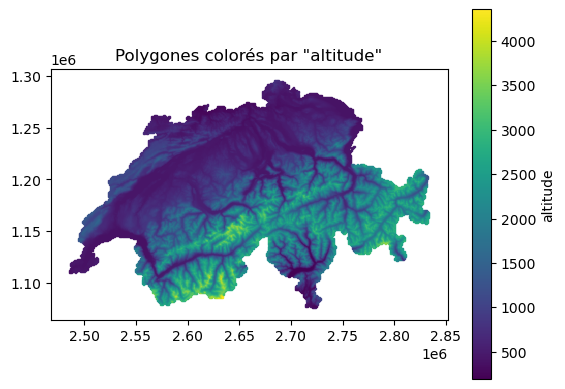

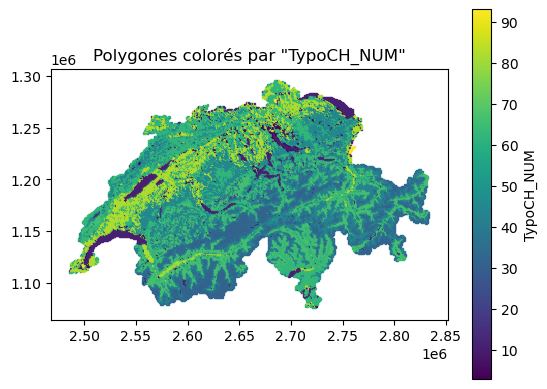

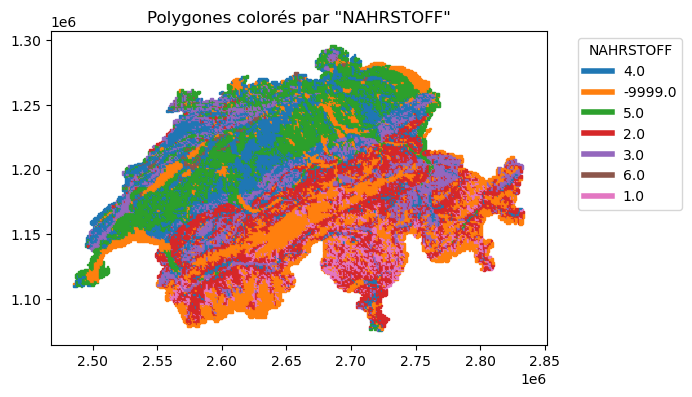

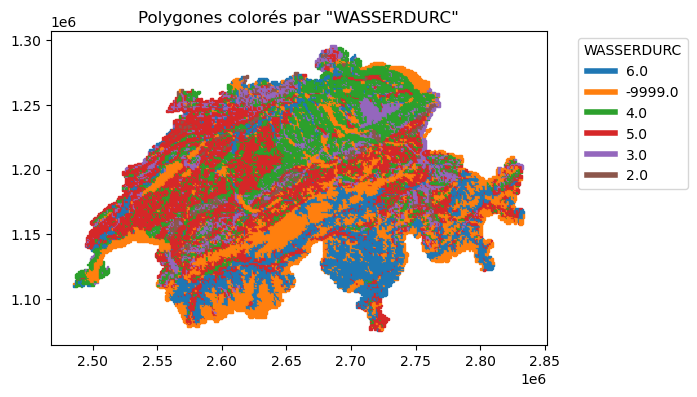

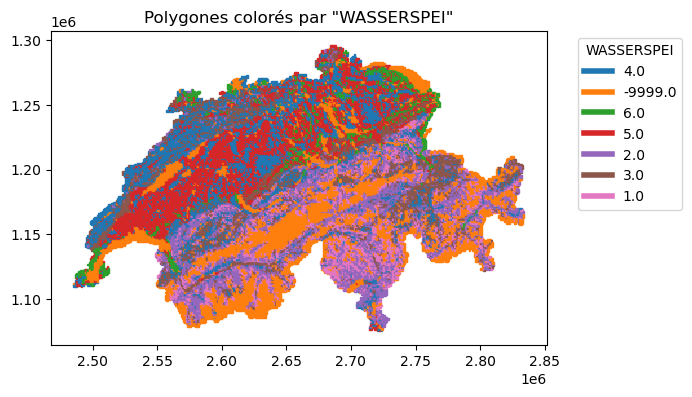

In [84]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np

df = resolved_gdf

# Définir une fonction pour créer une carte pour les colonnes continues
def create_continuous_map(dataframe, column_name):
    fig, ax = plt.subplots()

    # Définir une colormap continue
    colormap = plt.colormaps.get_cmap('viridis')
    normalize = mcolors.Normalize(vmin=dataframe[column_name].min(), vmax=dataframe[column_name].max())

    # Ajouter chaque polygone à l'axe avec la couleur basée sur la colonne
    for idx, row in dataframe.iterrows():
        polygon = row['geometry']
        value = row[column_name]
        color = colormap(normalize(value))
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color)

    # Ajouter une barre de couleur
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(column_name)

    # Configurer l'affichage
    ax.set_title(f'Polygones colorés par "{column_name}"')
    ax.set_aspect('equal', adjustable='box')

    # Afficher la figure
    plt.show()

# Définir une fonction pour créer une carte pour les colonnes catégorielles
def create_categorical_map(dataframe, column_name):
    fig, ax = plt.subplots()

    # Obtenir les catégories uniques et définir une colormap discrète
    categories = dataframe[column_name].unique()
    colormap = plt.colormaps.get_cmap('tab10')
    color_dict = {category: colormap(i) for i, category in enumerate(categories)}

    # Ajouter chaque polygone à l'axe avec la couleur basée sur la colonne
    for idx, row in dataframe.iterrows():
        polygon = row['geometry']
        value = row[column_name]
        color = color_dict[value]
        x, y = polygon.exterior.xy
        ax.fill(x, y, color=color)

    # Ajouter une légende
    handles = [plt.Line2D([0, 1], [0, 0], color=color_dict[category], lw=4) for category in categories]
    ax.legend(handles, categories, title=column_name, bbox_to_anchor=(1.05, 1), loc='upper left')


    # Configurer l'affichage
    ax.set_title(f'Polygones colorés par "{column_name}"')
    ax.set_aspect('equal', adjustable='box')

    # Afficher la figure
    plt.show()

# Créer une carte pour chaque colonne de données, en excluant 'idx', 'geometry', et 'Bodentyp'
excluded_columns = {'idx', 'geometry', 'Bodentyp'}
continuous_columns = {'altitude', 'TypoCH_NUM'}  # Spécifier les colonnes continues

for column in df.columns:
    if column not in excluded_columns:
        if column in continuous_columns:
            create_continuous_map(df, column)
        else:
            create_categorical_map(df, column)
